In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from stochastic.processes import FractionalBrownianMotion
from torch.utils.data import TensorDataset, DataLoader, Dataset


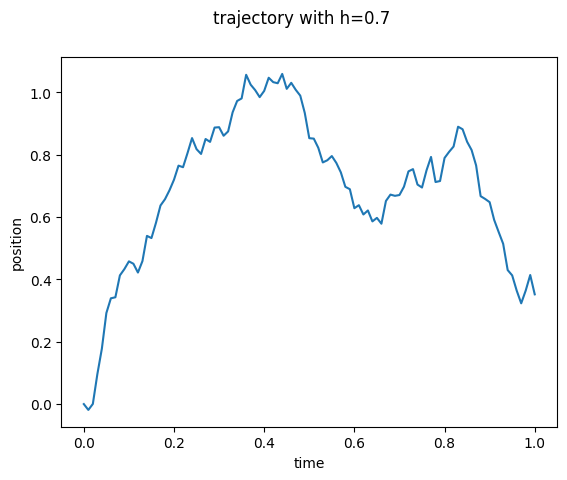

In [42]:
#Quick sanity to check whether the fbm library is working

f = FractionalBrownianMotion(hurst=0.7, t=1)
# Generate a fBm realization
fbm_sample = f.sample(100)
# Get the times associated with the fBm
t_values = f.times(100)
plt.plot(t_values[:10000], fbm_sample[:10000])
plt.xlabel('time')
plt.ylabel('position')
plt.suptitle("trajectory with h=0.7")
plt.show()

# Define helper functions

In [43]:
def generate_dataset(N_SIMS:int, trajectory_length:int):

  X=np.zeros((N_SIMS,trajectory_length ,1)) #Create empty X vector 
  Y=np.zeros(N_SIMS) #Create empty y vector



  for i in range(N_SIMS):
    h=round(np.random.uniform(0.01,0.90), 4) #Choose Hurst paramenter from uniform distribution (only take the first 4 decimal digits)
    f = FractionalBrownianMotion(hurst=h, t=1)
    X[i]= f.sample(trajectory_length-1).reshape(trajectory_length, 1)
    Y[i]=h

    if i%10000 == 0:
      print('Simulations Generated:',i)

  Y=Y.reshape(-1,1)

  #Split train and test datasets (70/30)
  X_train=X[:int(N_SIMS*0.7)]
  Y_train=Y[:int(N_SIMS*0.7)]


  X_test=X[int(N_SIMS*0.7):]
  Y_test=Y[int(N_SIMS*0.7):]

  return X_train, Y_train, X_test, Y_test

In [44]:
def DatasetMAE(loader, model):
  loss=0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
      for x, y in loader:
          x = x.to(device=device) # move to device, e.g. GPU
          y = y.to(device=device)
          scores = model(x)

          loss+=(torch.abs(scores-y)).sum()
          num_samples += scores.size(0)

      print('Got an overall MAE of ', loss.item()/num_samples)
  return loss.item()/num_samples    #Return average loss

class SimulationDatset(Dataset):

  def __init__(self, X, Y):

    #scaling features
    X=(X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True) #Normalize X
    Y=Y #No need to normalize y

    #converting to torch tensors
    self.X=torch.tensor(X, dtype=torch.float32)
    self.Y=torch.tensor(Y, dtype=torch.float32)

  def __len__(self):
      return len(self.Y)

  def __getitem__(self, idx):
      return self.X[idx], self.Y[idx]
      

In [45]:
class DeepBrownianEncoder(torch.nn.Module):

    def __init__(self, embedding_dim=1, num_layers=1, num_heads=1, trajectory_length=102):
        super(DeepBrownianEncoder, self).__init__()

        self.embedding_dim=embedding_dim
        self.num_layers=num_layers
        self.num_heads=num_heads
        self.trajectory_length=trajectory_length
        
        self.linear1 = torch.nn.Linear(1, embedding_dim)
        self.encoder_layer = torch.nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=self.num_layers)
        self.linear2 = torch.nn.Linear(self.trajectory_length*self.embedding_dim, 1)



    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.linear1(x)
        x = self.transformer_encoder(x)
        x = x.view(batch_size, -1)
        x = self.linear2(x)
        return x

In [46]:
def train(dataloader, model, loss_fn, optimizer):
    losses=[]
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    return losses

# Train

In [47]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [48]:
N_SIMS=100000  #Number of simulations
trajectory_length=102   #Number of samples per simulation
batch_size=10
learning_rate=1e-3


X_train, Y_train, X_test, Y_test = generate_dataset(N_SIMS, trajectory_length)

train_data=SimulationDatset(X_train, Y_train)
train_loader=DataLoader(train_data, batch_size=batch_size)

test_data=SimulationDatset(X_test, Y_test)
test_loader=DataLoader(test_data, batch_size=batch_size)


model=DeepBrownianEncoder(embedding_dim=8, num_layers=3, num_heads=2).to(device)
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Simulations Generated: 0
Simulations Generated: 10000
Simulations Generated: 20000
Simulations Generated: 30000
Simulations Generated: 40000
Simulations Generated: 50000
Simulations Generated: 60000
Simulations Generated: 70000
Simulations Generated: 80000
Simulations Generated: 90000


In [49]:
epochs = 3
losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss=train(train_loader, model, loss_fn, optimizer)
    losses+=(loss)
    DatasetMAE(test_loader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.291704  [   10/70000]
loss: 0.153065  [ 1010/70000]
loss: 0.110716  [ 2010/70000]
loss: 0.049002  [ 3010/70000]
loss: 0.094187  [ 4010/70000]
loss: 0.039506  [ 5010/70000]
loss: 0.034961  [ 6010/70000]
loss: 0.028185  [ 7010/70000]
loss: 0.025405  [ 8010/70000]
loss: 0.074738  [ 9010/70000]
loss: 0.057182  [10010/70000]
loss: 0.097863  [11010/70000]
loss: 0.035530  [12010/70000]
loss: 0.047636  [13010/70000]
loss: 0.069800  [14010/70000]
loss: 0.055744  [15010/70000]
loss: 0.039477  [16010/70000]
loss: 0.041662  [17010/70000]
loss: 0.180813  [18010/70000]
loss: 0.025478  [19010/70000]
loss: 0.044872  [20010/70000]
loss: 0.032194  [21010/70000]
loss: 0.041969  [22010/70000]
loss: 0.069447  [23010/70000]
loss: 0.042545  [24010/70000]
loss: 0.037415  [25010/70000]
loss: 0.051096  [26010/70000]
loss: 0.023754  [27010/70000]
loss: 0.031326  [28010/70000]
loss: 0.052987  [29010/70000]
loss: 0.057159  [30010/70000]
loss: 0.023022  [31010/70000]


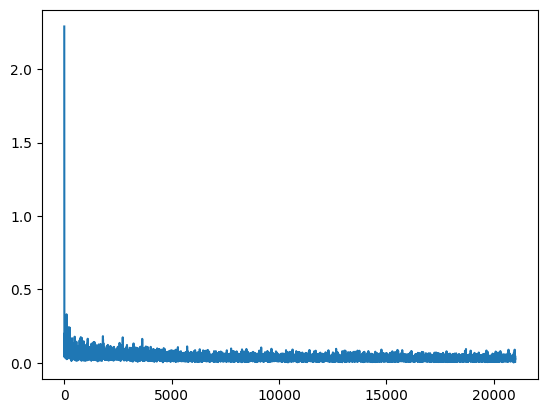

In [50]:
plt.plot(losses)

In [54]:
#Save model
torch.save(model.state_dict(), 'model/model_weights.pth')

In [52]:
#Load the model
